/Users/davidangeles/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



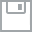
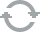
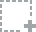
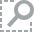
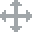
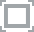
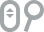
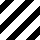
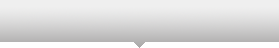
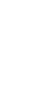
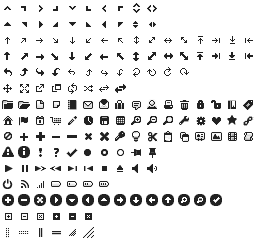
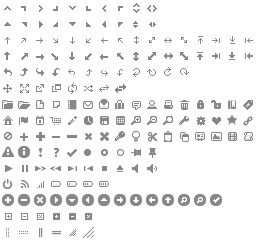
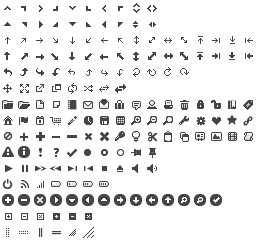
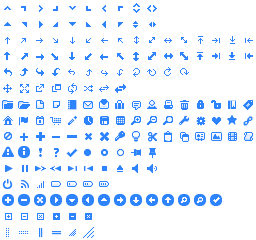
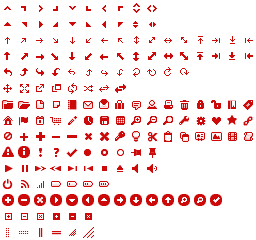
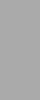
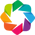
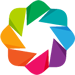

In [1]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Bokeh stuff
import bokeh.charts
import bokeh.io
import bokeh.charts.utils
import bokeh.models
import bokeh.palettes
import bokeh.plotting

bokeh.io.output_notebook()


In [12]:
df= pd.read_csv('/Users/davidangeles/Downloads/dan_data.csv', sep= ',')

In [22]:
df.head(10)

Date                                                 C1  \
0  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-2   
1  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-2   
2  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-2   
3  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-3   
4  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-3   
5  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-3   
6  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-4   
7  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-4   
8  2015.11.02      100uL.gamma.decalactone.in.mineral.oil,.10^-4   
9  2015.10.30  100uL.trans-3.hexenyl.acetate.in.mineral.oil.1...   

                  C2  nC1  nC2   sex genotype  
0  100uL.mineral.oil   36   82  male    him-5  
1  100uL.mineral.oil   52   56  male    him-5  
2  100uL.mineral.oil   59   38  male    him-5  
3  100uL.mineral.oil   36   30  male    him-5  
4  100uL.mineral.oil   35   70  male    him-5  
5  100uL.mineral.oil   24   74  male    him-5  
6  100uL.mineral.oil   35   52  male    him-5  
7  100uL.mineral.oil   18   53  male    him-5  
8  100uL.mineral.oil   30   39  male    him-5  
9  100uL.mineral.oil    0   65  male    him-5

In [28]:
def log_post(p, alpha, beta, n_att, n_c):
    """
    Given parameters 'p', and two hyperparameters 'pbar' and 'sigma',
    return the log posterior distribution on data N_att and N (N>N_att always)
    """  
    
    if alpha <= 0 or beta <= 0:
        return -np.inf
    else:
        logBetaFunc= scipy.special.gammaln(alpha+beta)\
        -scipy.special.gammaln(alpha)-scipy.special.gammaln(beta)
        
        return np.log(scipy.misc.comb(n_att+n_c, n_att)) \
                + (n_att+alpha-1)*np.log(p)+(n_c+beta-1)*np.log(1-p) + logBetaFunc

def log_post_hierarchical(params, N_att, N_c):
    """
    A hierarchical beta-binomial model. 
    Given m assays (N_att, N_c), calculate most probable
    coins p_i's for each assay and calculate
    most likely beta distribution that generated these
    coins.
    """      
    if type(N_att) in [int, float]:
        N_att= [N_att]
    
    if type(N_c) in [int, float]:
        N_c= [N_c]
        
    ps= params[0:len(N_att)] #first N_att parameters are p's
    U= params[len(N_att)]
    V= params[len(N_att)+1]

    if type(ps) in [int, float]:
        ps= [ps]
    
    
    
    alpha= U*V
    beta= (1-U)*V
    
    #the following conditions ensure 'bell shape' of the distribution (two inflection points)
    if alpha < 2:
        return -np.inf
    elif beta < 2:
        return -np.inf
    elif alpha+beta <= 3:
        return -np.inf
    elif any(i < 0 for i in ps): #no p's should be <0
        return -np.inf
    elif any(i > 1 for i in ps): #no p's should be >1
        return -np.inf
    else:
        
        lp= 0
        
        #calculate the likelihood
        for i, p in enumerate(ps):
            n_att= N_att[i]
            n_c= N_c[i]
            
            lp= lp + log_post(p, alpha, beta, n_att, n_c)
        
        #add the prior for V, which is close to a pareto(1.5) distribution (prior for U is uniform(0,1))
        lp= lp +np.log(1.5)-2.5*np.log(V)
    
        return lp
    
def mcmc(natt, nc, threads= 4, n_burn= 5000, n_steps= 5000, a= 2):
    """
    A parser that sets up and executes an emcee-based MCMC for a
    hierarchical binomial beta distribution. 
    Takes in two lists of data (natt, nc) and returns an
    EnsembleSampler object. 
    """
    
    lenP= len(natt)     #no. of dimensions scales with no. of assays
    n_dim = 2 + lenP       # number of parameters in the model
    n_walkers = 200   # number of MCMC walkers
    
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    #initialize parameters
    #first, do the individual p's
    for i in np.arange(lenP):
        #because the computation seems to be slow, start the walkers near their predicted optima:
        popt= natt[i]/(natt[i]+nc[i])
        p0[:,i]= np.random.uniform(0,1, n_walkers)
    
    #hyperparameters, U= alpha/(alpha+beta) V= alpha+beta
    meanp= np.mean(natt/(natt+nc)) #a good guess for mean of beta dist
    p0[:,lenP] = np.random.normal(meanp, .1, n_walkers) #mean U, initialized v. near the optimum, bc weird otherwise...
    
    #remove all points above 1 and below zero, since they won't walk well. 
    #find any points i where i > 1:
    temp= p0[np.where(p0[:, lenP] > 1), lenP]
    p0[np.where(p0[:, lenP] > 1), lenP]= 1 
    
    #find any points where i < 0
    temp= p0[np.where(p0[:, lenP] < 0), lenP]
    p0[np.where(p0[:, lenP] < 0), lenP]= 0


    p0[:,lenP+1] = np.random.gamma(20, 1, n_walkers) #scale V
        
    #set up the sampler
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_hierarchical, 
                                args=(natt, nc,), threads= threads, a= a)
    
    #Do burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    
    # Sample again, starting from end burn-in state
    _ = sampler.run_mcmc(pos, n_steps) 
    
    return sampler

def HPD(trace, p= 0.95):
    """
    Return HPD of any given trace
    """
    
    d= np.sort(np.copy(trace))
    n= len(d)
    n_samples= np.int(np.floor(n*p))
    width= d[n_samples:]-d[:n-n_samples]
    min_width_ind= np.argmin(width)
    
    return [d[min_width_ind],d[min_width_ind+n_samples]]

def find_mode_and_hpd(sampler, lenP):
    """
    Given an emcee EnsembleSampler object, number of coins tossed
    Find mode and hpd for all parameters and hyperparameters.
    
    Warning: Returns HPD as a tuple, centered around 0 (to feed into matplotlib's errorbar function)
    """

    hpd_p= np.zeros(shape= [lenP, 2])
    modes_p= np.zeros(shape= [lenP, 1])
    for i in np.arange(lenP):
        modes_p[i] = sampler.flatchain[np.argmax(sampler.flatlnprobability)][i]
        hpd_p[i, :]= np.absolute(HPD(sampler.flatchain[:, i])-modes_p[i])
    
    hpd_U= np.zeros(shape= [1, 2])
    
    mode_U= sampler.flatchain[np.argmax(sampler.flatlnprobability)][lenP]
    hpd_U[0, :]= np.abs(HPD(sampler.flatchain[:, lenP], .95)-mode_U)
        
    return modes_p, hpd_p, mode_U, hpd_U

def plot_with_error_bars(mode_p, mode_u, perr, betaerr, ax, x_mean= 0, x_sigma= 0.06):
    """
    A function that plots points with error bars
    Error bars typically are HPD bars
    Data points are in blue; Beta Average is in Green
    Plots one at a time
    """
    
    x= np.random.normal(x_mean, x_sigma, len(mode_p))
    x= x+x_mean-np.mean(x) #whatever the random numbers, make them centered at x_mean
    
    ax.errorbar(x, modes_p, yerr= perr, fmt= 'o', markersize= 7, color= 'b')
    ax.errorbar(np.mean(x), mode_u, yerr= betaerr, fmt= 'o', markersize= 15, alpha= 0.7, color= 'r', elinewidth= 3)    
    return np.mean(x)

def axis_fixer(xlims, ylims, xtick_pos, ytick_pos, ax, xtick_labels= [], labels= []):
    """
    A function to fix the axes on a plot
    """
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_yticks(np.sort(ytick_pos))
    ax.set_xticks(np.sort(xtick_pos))
    
    if len(xtick_labels) > 0:
        #ax.set_xticklabels(xtick_labels)
        plt.xticks(xtick_pos, xtick_labels, rotation='45')
        
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=15)
    
    if len(labels) > 0:
        title= labels[0]
        xlab= labels[1]
        ylab= labels[2]
        ax.set_title(title, fontsize=20)
        ax.set_ylabel(ylab, fontsize= 17)
        ax.set_xlabel(xlab, fontsize= 25)

In [17]:
df.head()

#get unique identifiers for c1, c2, sex and genotype
c1_classes= df.C1.unique()
c2_classes= df.C2.unique()
sexes= df.sex.unique()
genotypes= df.genotype.unique()

#check to make sure all data is input correctly
print('there are {0} classes for c1, {1} classes for c2, {2} sex and {3} genotypes'\
      .format(len(c1_classes),len(c2_classes),len(sexes),len(genotypes)))

there are 38 classes for c1, 5 classes for c2, 1 sex and 1 genotypes


In [20]:
grouped= df.groupby(['C1', 'C2', 'sex', 'genotype'])

a= 2 #acceptance scale factor for mcmc
i= 0
labels= ['Chemoattraction Assays Renewed', 'Conditions', 'Chemoattraction Probability']
maxI= 5
Mode_u= np.zeros(shape= (maxI, 1)) #number of groups, no. of values

                                  p1   p2   p3   pbar
Best guess for the parameters:  0.95  0.97  0.93  0.92
Raw estimates and raw mean:     0.94  0.98  0.93  0.95
                                  p1   p2   p3   pbar
Best guess for the parameters:  0.91  0.69  0.81  0.74
Raw estimates and raw mean:     0.92  0.69  0.8  0.81
                                  p1   p2   p3   pbar
Best guess for the parameters:  0.28  0.57  0.76  0.5
Raw estimates and raw mean:     0.28  0.56  0.76  0.53
                                  p1   p2   p3   pbar
Best guess for the parameters:  0.0038  0.0016  0.0021  0.0044
Raw estimates and raw mean:     0.013  0.0  0.0  0.0043
                                  p1   p2   p3   pbar
Best guess for the parameters:  0.37  0.19  0.19  0.33
Raw estimates and raw mean:     0.38  0.19  0.2  0.25


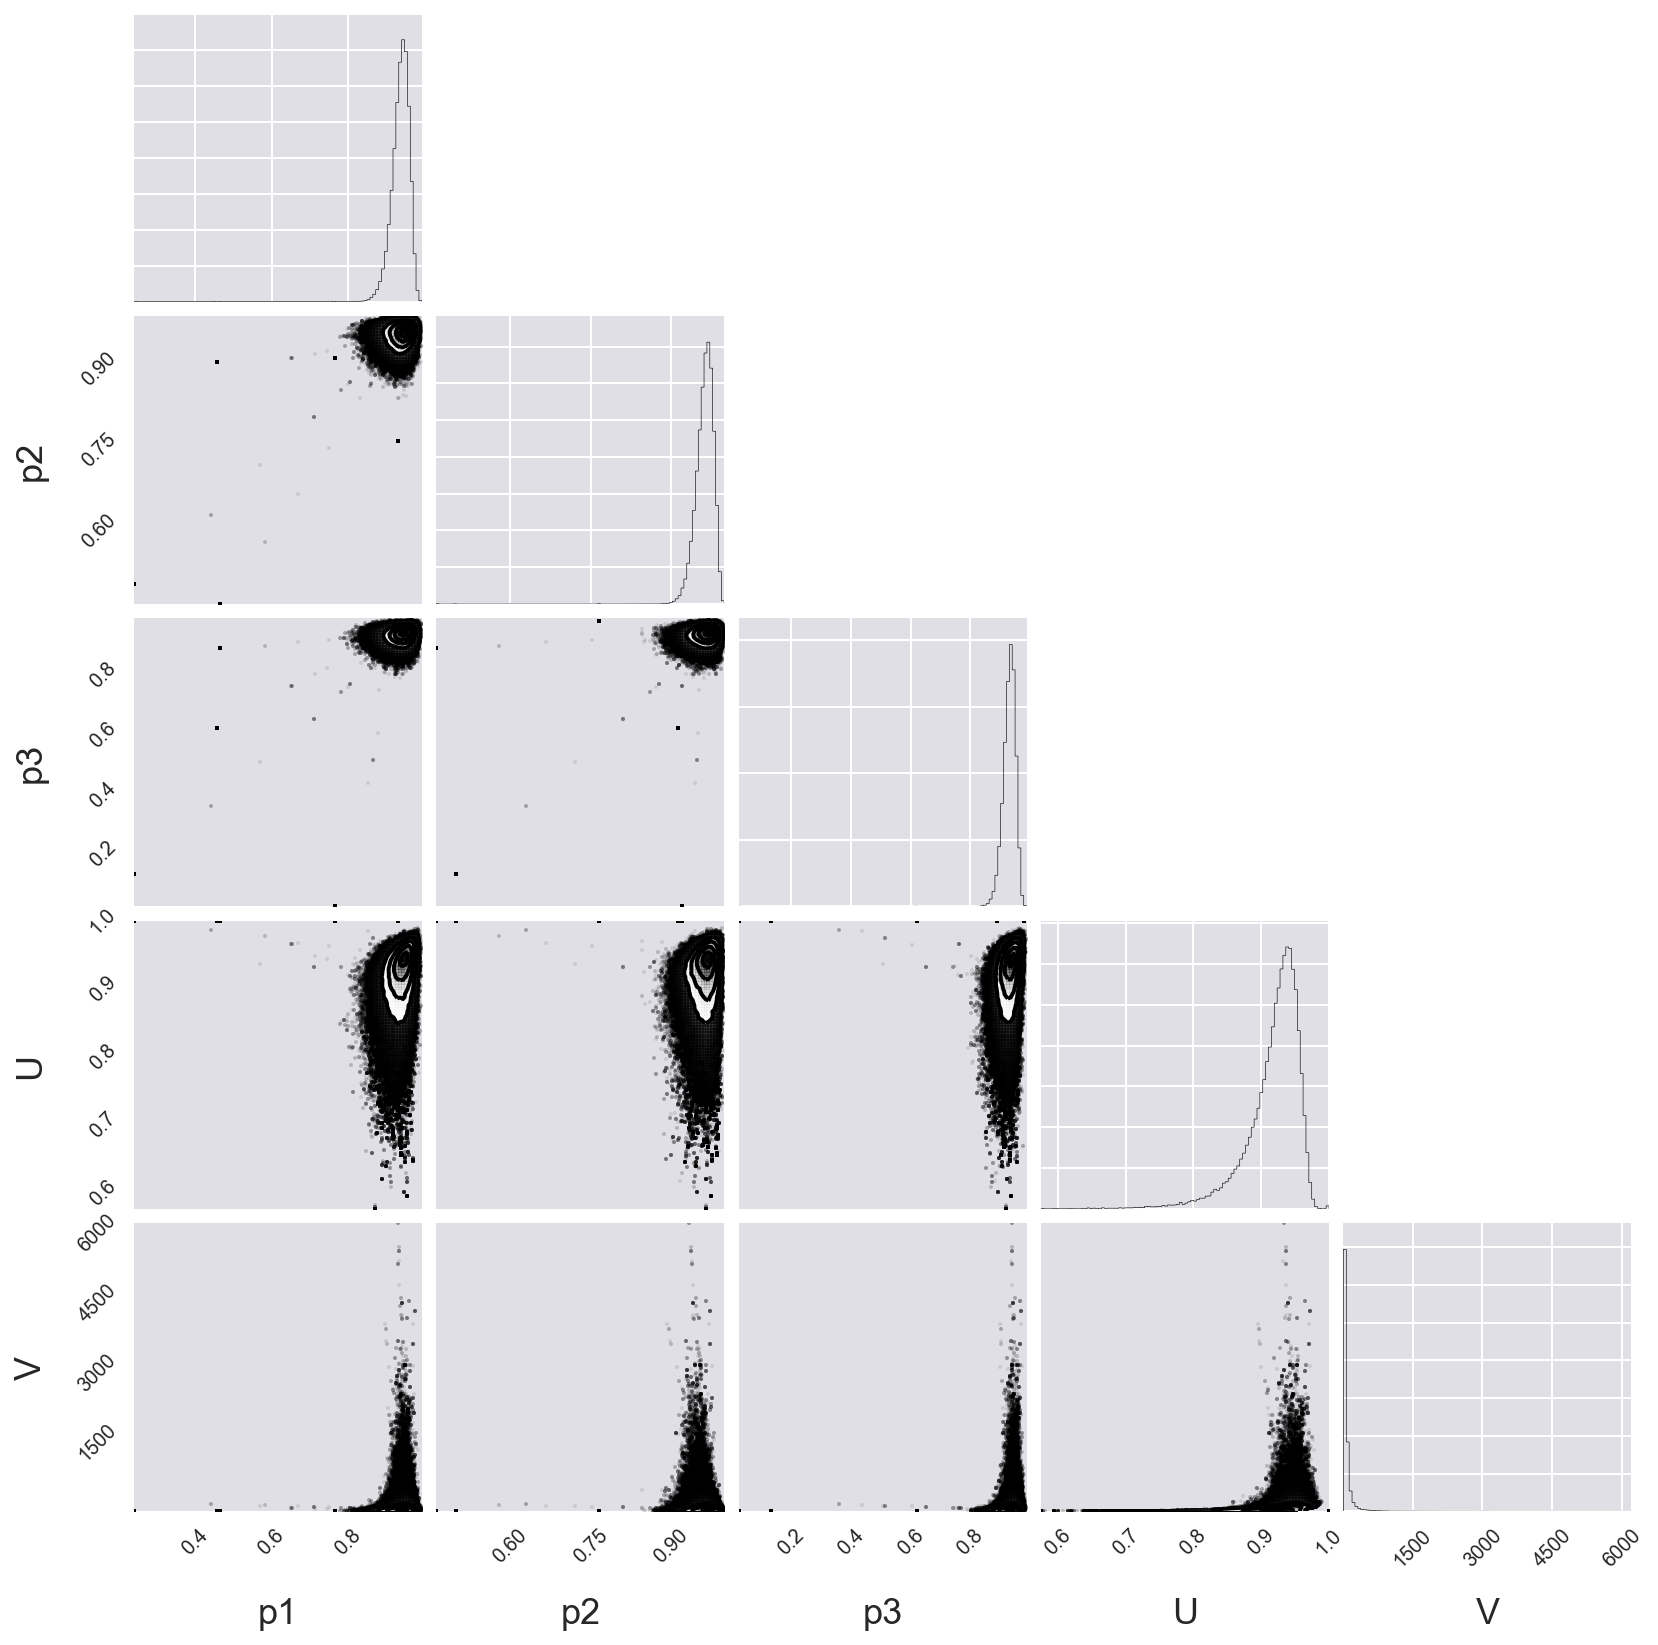

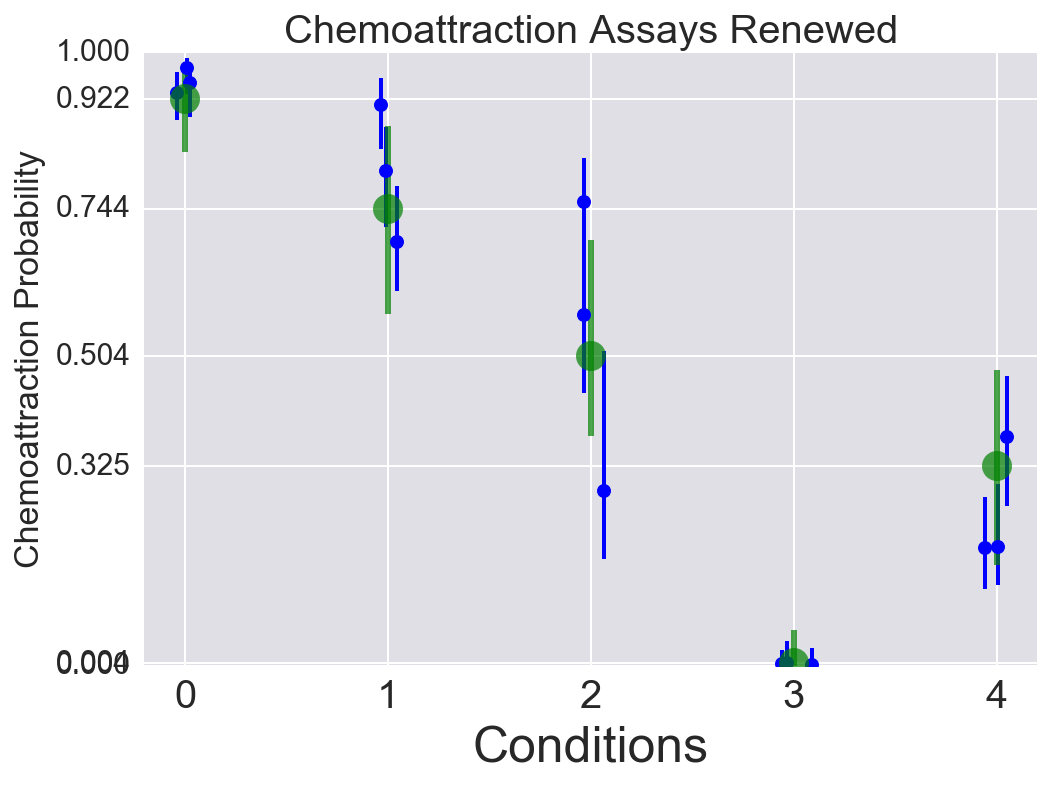

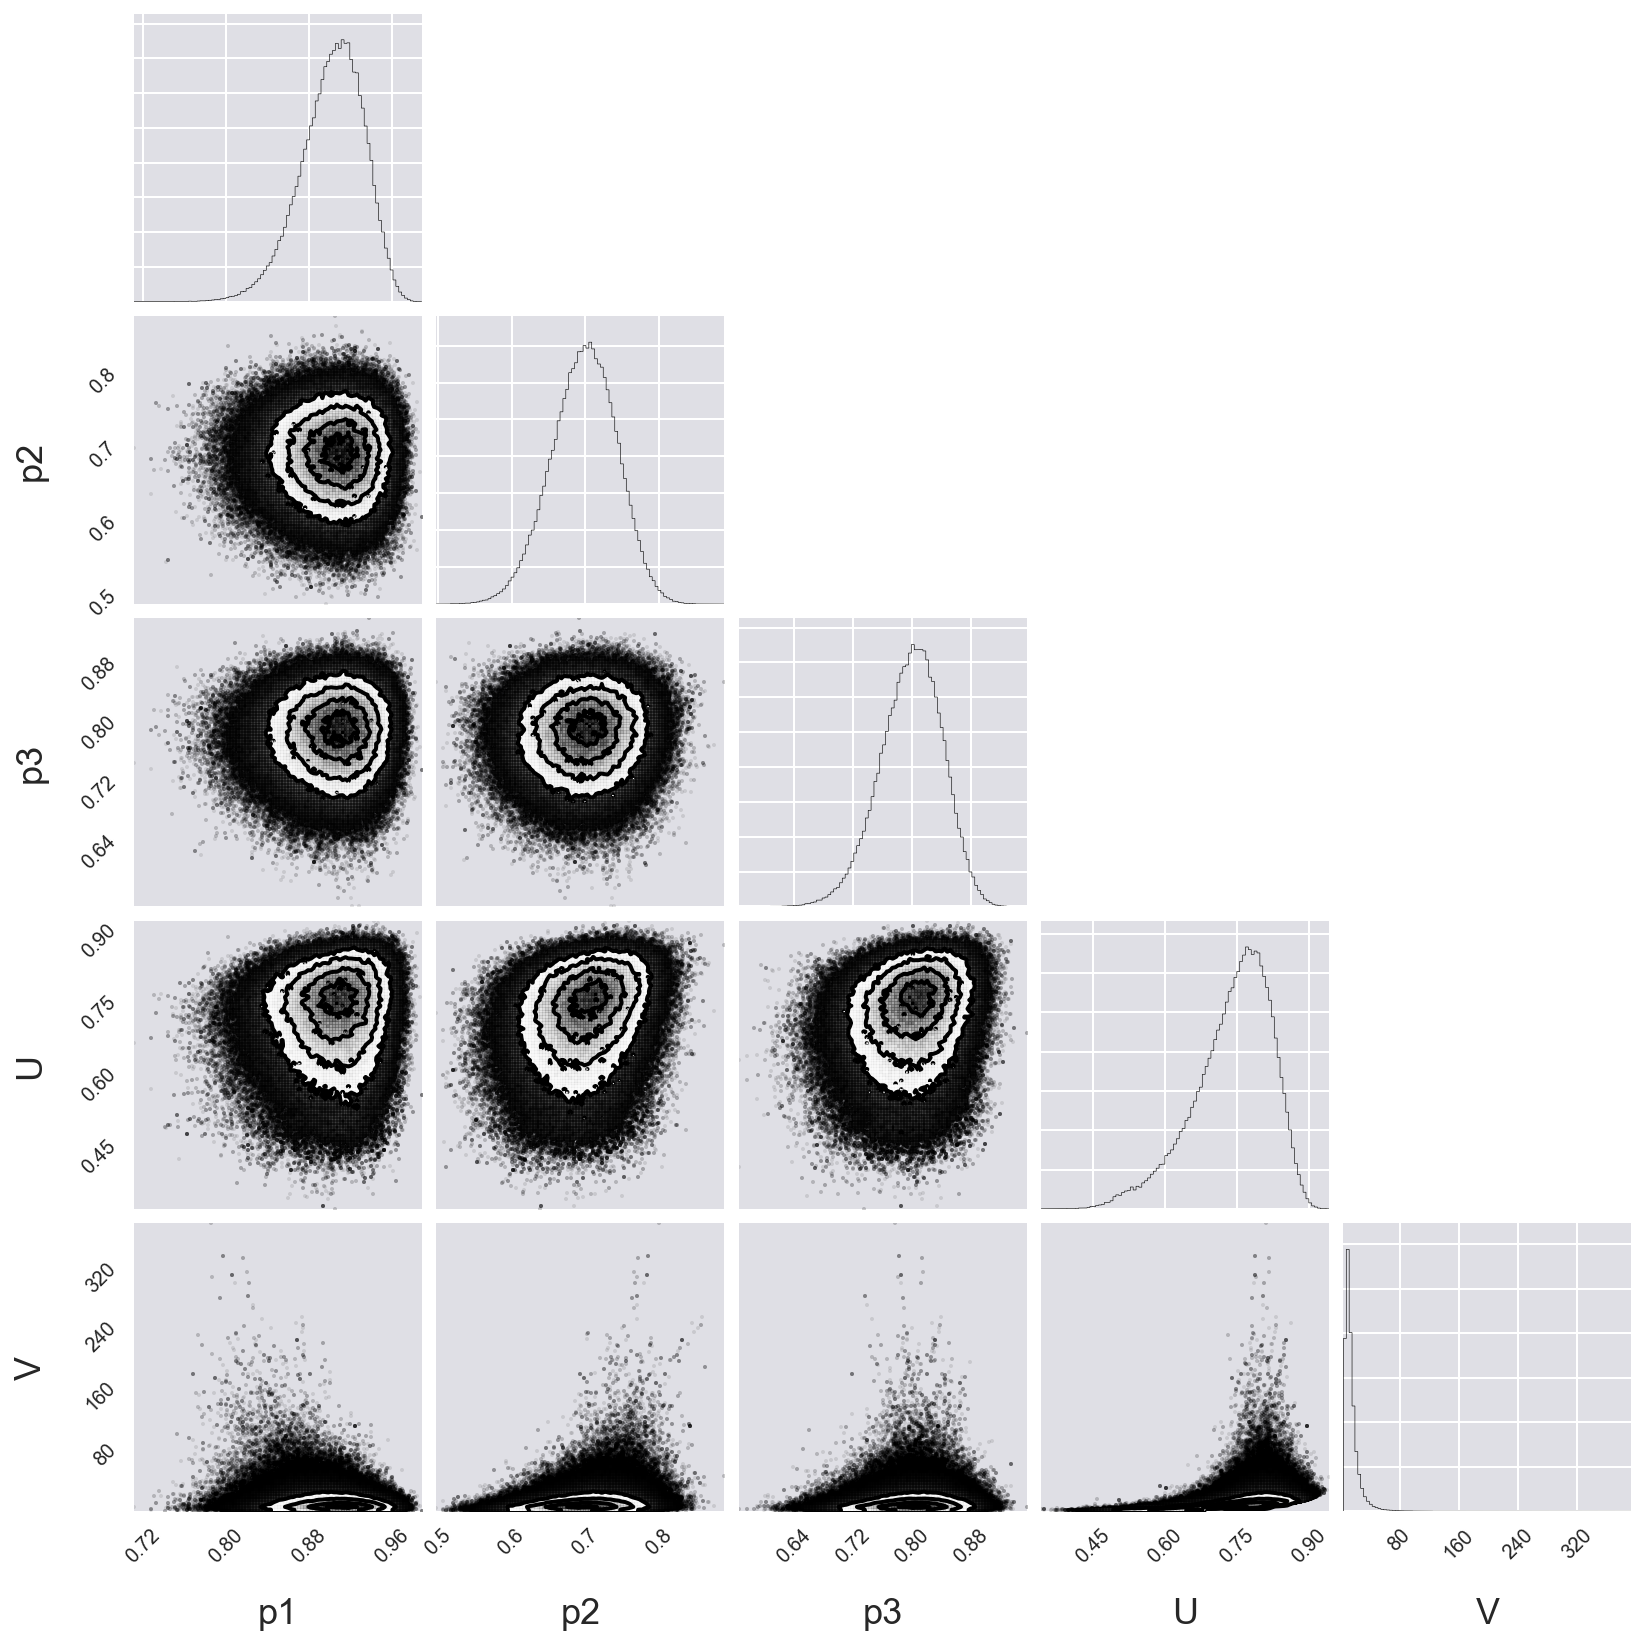

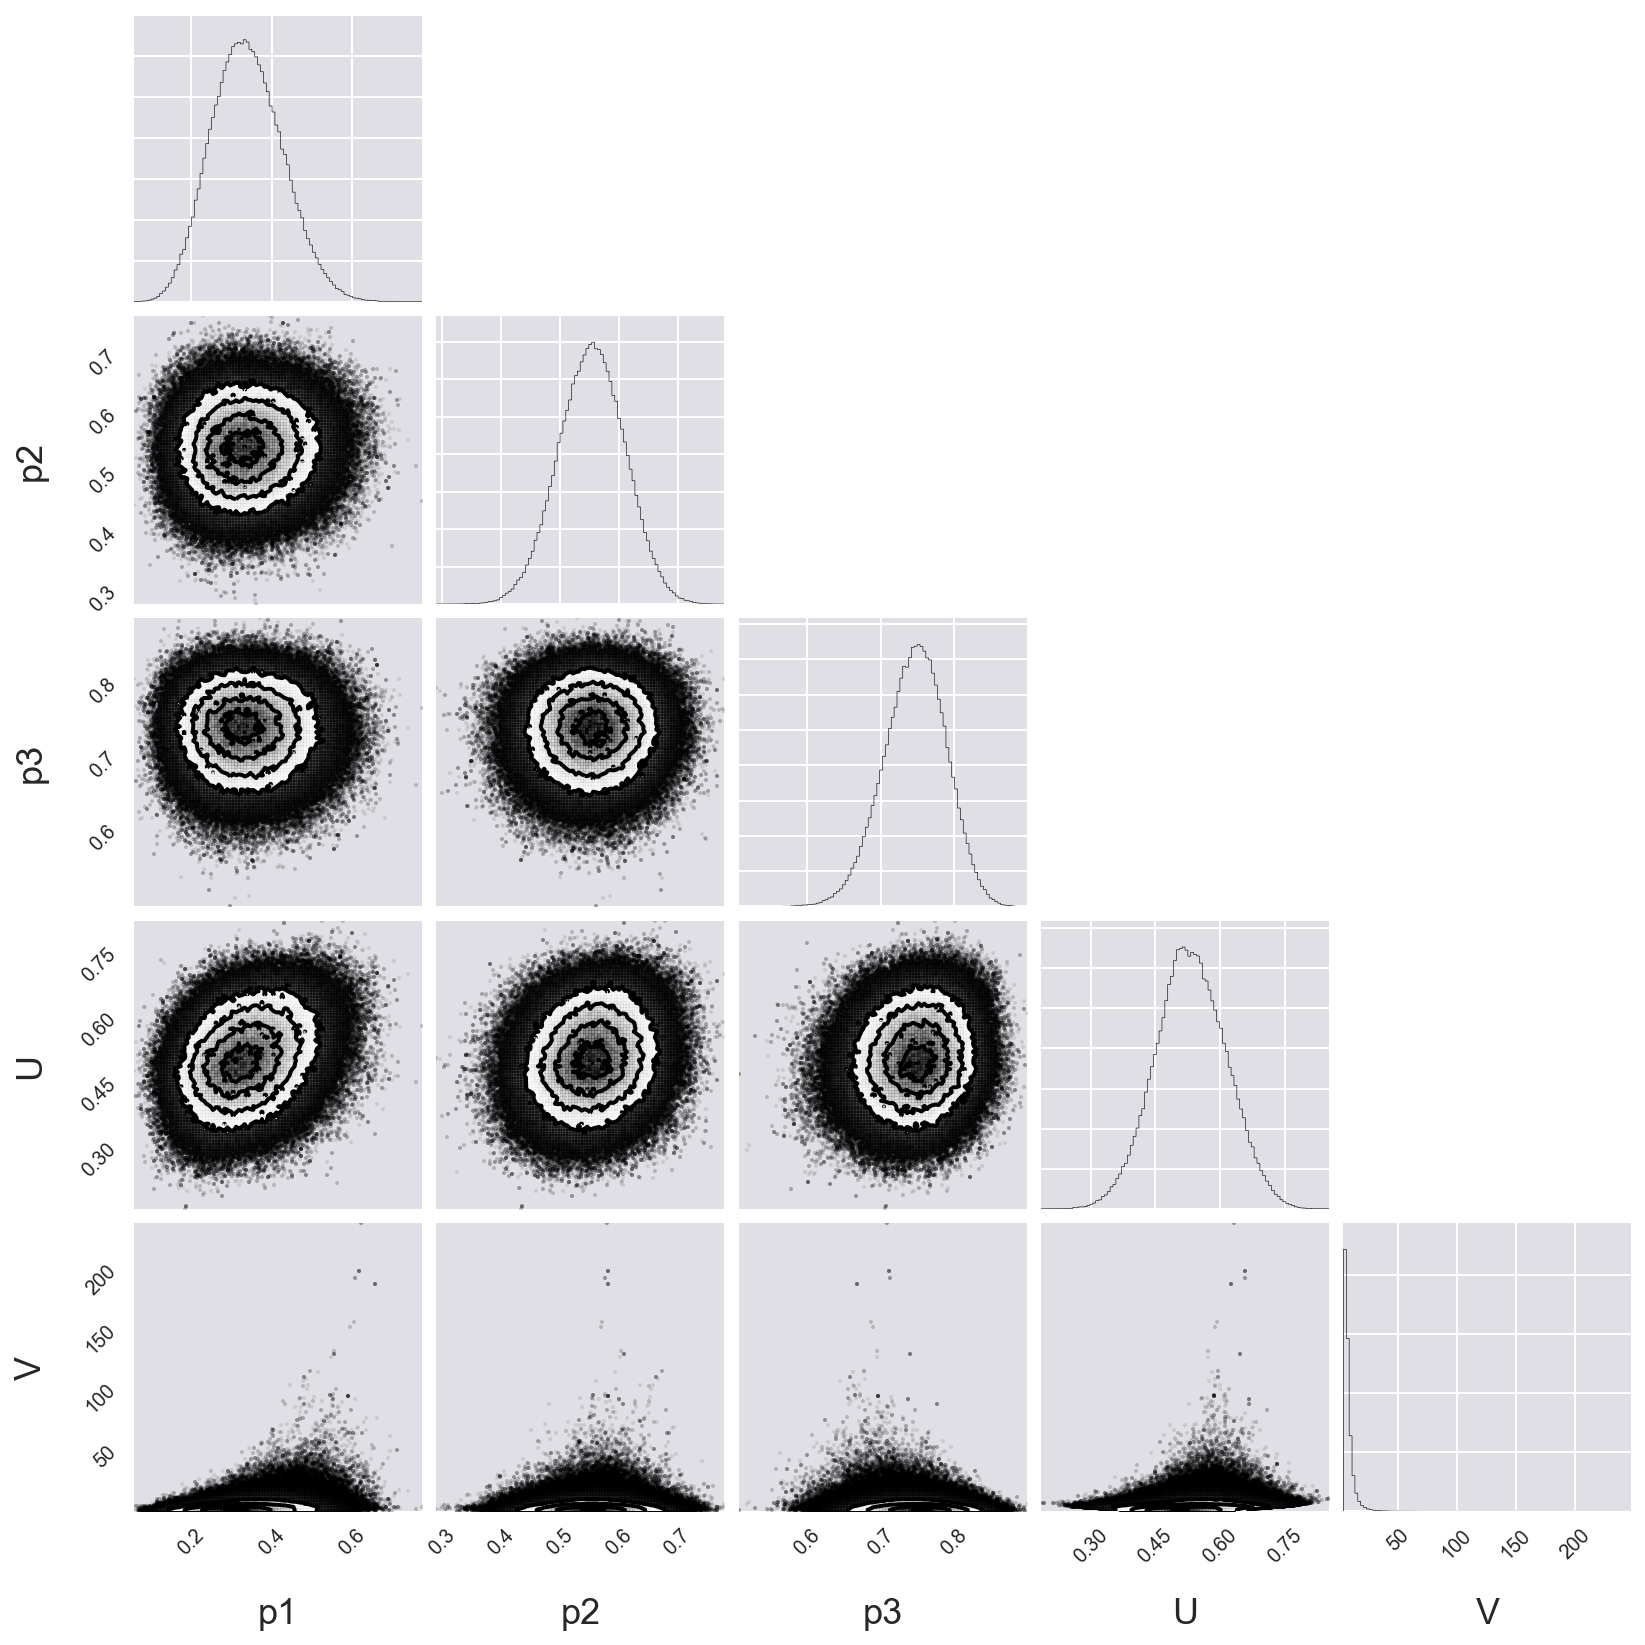

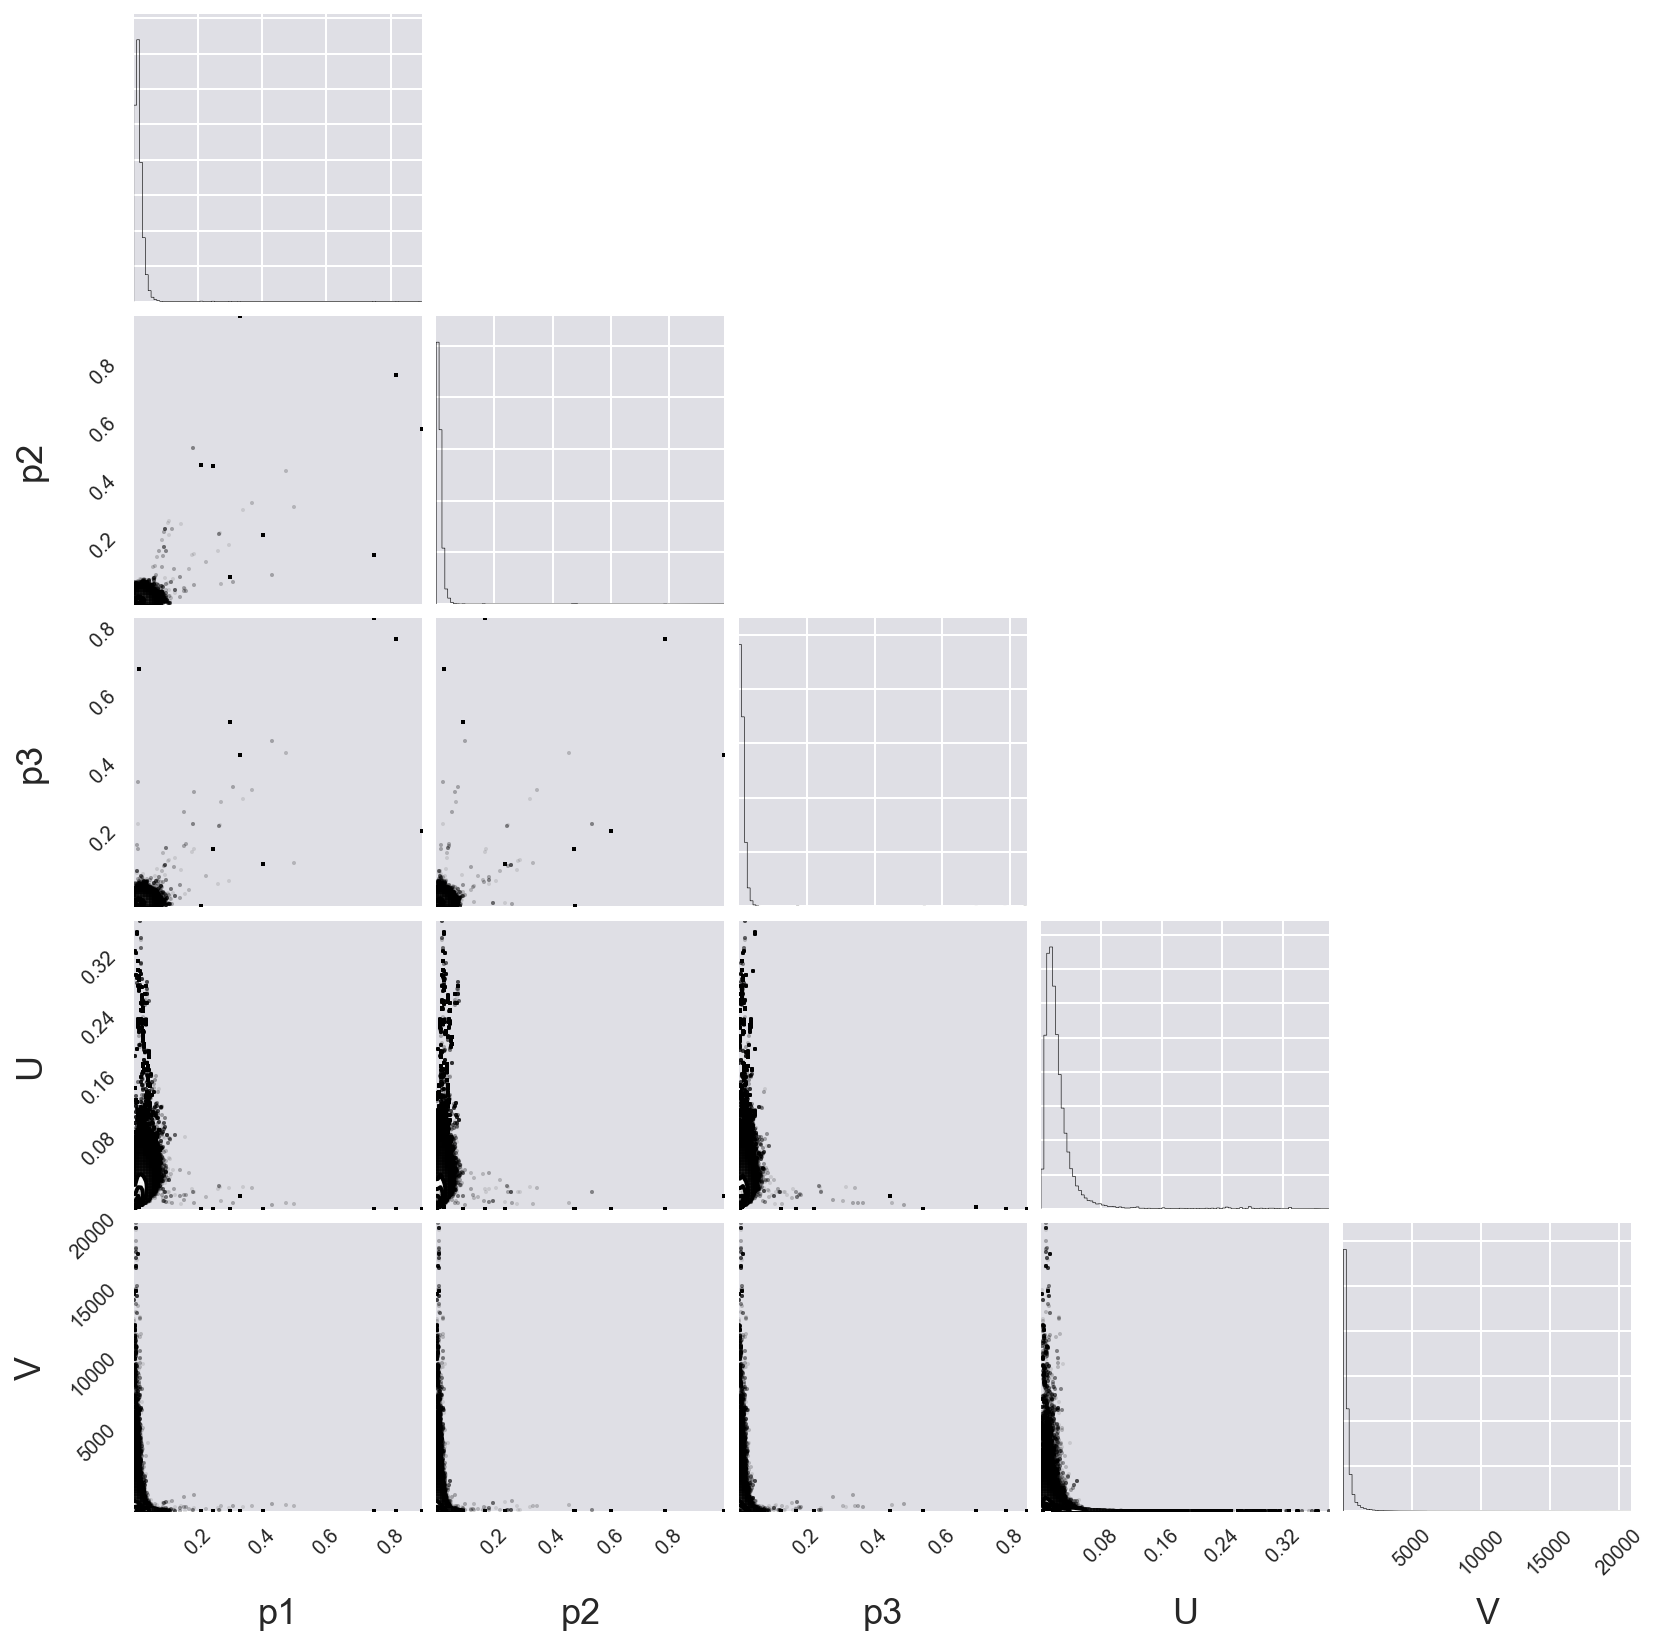

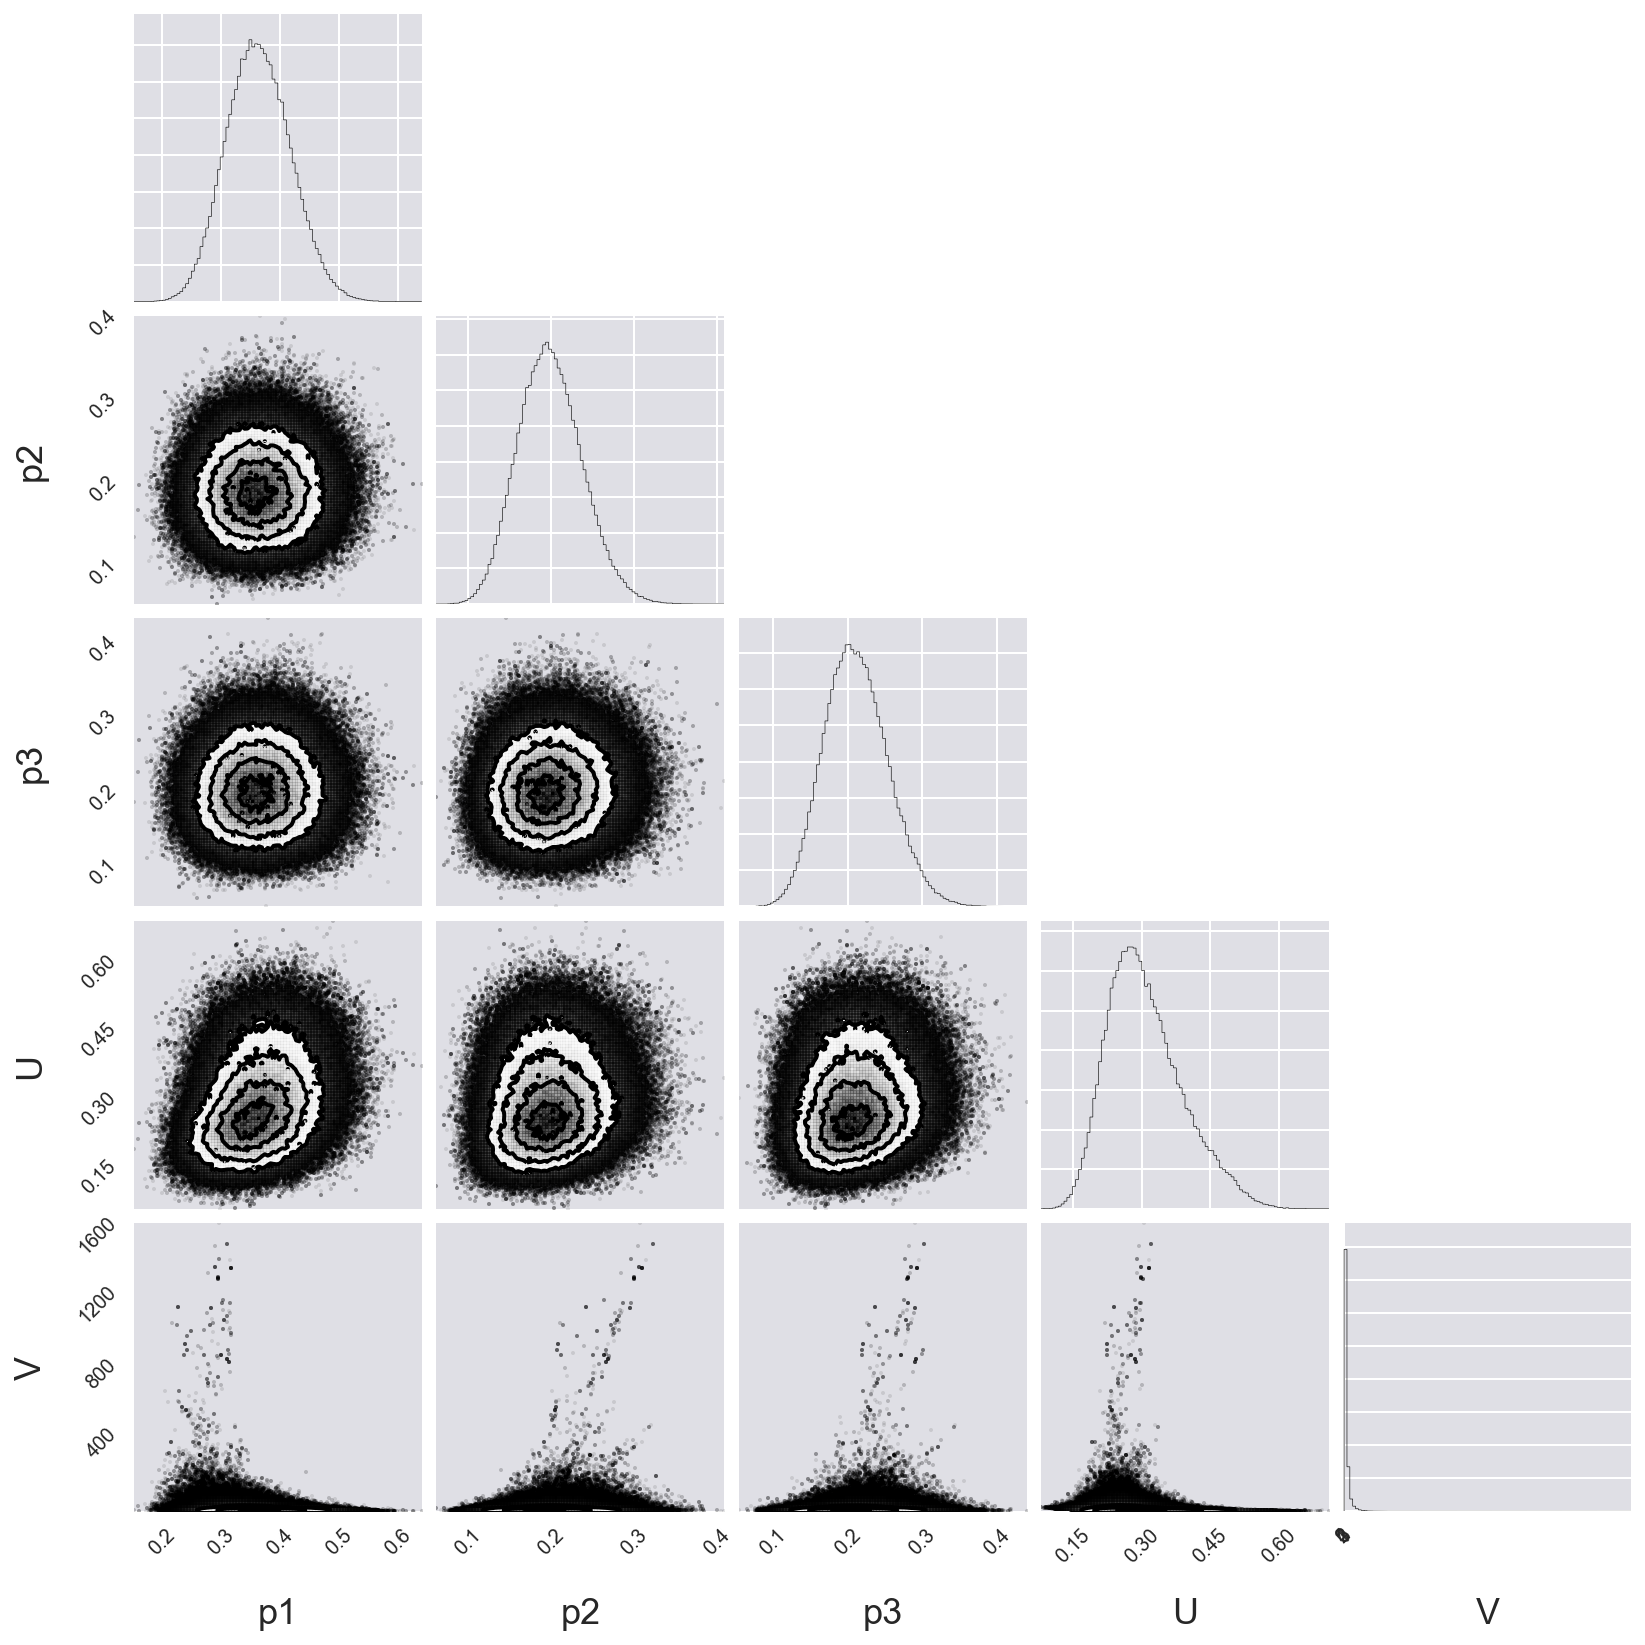

In [21]:
for keys, group in grouped:
    
    natt= group.nC1.values
    nc= group.nC2.values
    
    sampler= mcmc(natt, nc, threads= 6, n_burn= 500, n_steps= 5000, a= a)
    
    fig = corner.corner(sampler.flatchain, labels=['p1', 'p2','p3', 'U', 'V'], bins=100)
    
    #get the mode of each prob. parameter p and its hpd, as well as for the mean of beta and its hpd
    modes_p, hpd_p, mode_u, hpd_u= find_mode_and_hpd(sampler, len(natt))
    
    #place the mode of the mean of the beta distribution in an array
    Mode_u[i]= mode_u
    #Mode_p[i, :]= modes_p
    
    betaerr= [[hpd_u[0][0]], [hpd_u[0][1]]]
    
    #initialize an axis
    if i == 0:
        fig, ax= plt.subplots()

    #if np.mean(sampler.acceptance_fraction) > 0.4:
    #    print('acceptance fraction too high', sampler.acceptance_fraction.mean())
    #    break
    
    #plot the current modes and their hpds
    plot_with_error_bars(modes_p, mode_u, np.transpose(hpd_p), betaerr, ax= ax, x_mean= i)
        
    #fig = corner.corner(sampler.flatchain, labels=['p1', 'p2','p3', 'U', 'V'], bins=60)
    
    i+= 1
    
    #print(sampler.acceptance_fraction.mean())
    
    max_ind = np.argmax(sampler.flatlnprobability)
    
    #print some useful info about the parameters
    print("                                  p1   p2   p3   pbar")
    print("Best guess for the parameters:  {0:.2}  {1:.2}  {2:.2}  {3:.2}"\
      .format(sampler.flatchain[max_ind][0],sampler.flatchain[max_ind][1],sampler.flatchain[max_ind][2],sampler.flatchain[max_ind][3]))
    print("Raw estimates and raw mean:     {0:.2}  {1:.2}  {2:.2}  {3:.2}"\
      .format( (natt/(natt+nc))[0], (natt/(natt+nc))[1], (natt/(natt+nc))[2], np.mean(natt/(natt+nc))))
    if i >= maxI:
        break
        
Mode_u= np.append(Mode_u, [0,1])
axis_fixer([-.2, i-1+.2], [0, 1], np.arange(0, i), Mode_u, ax, np.arange(0, i), labels)

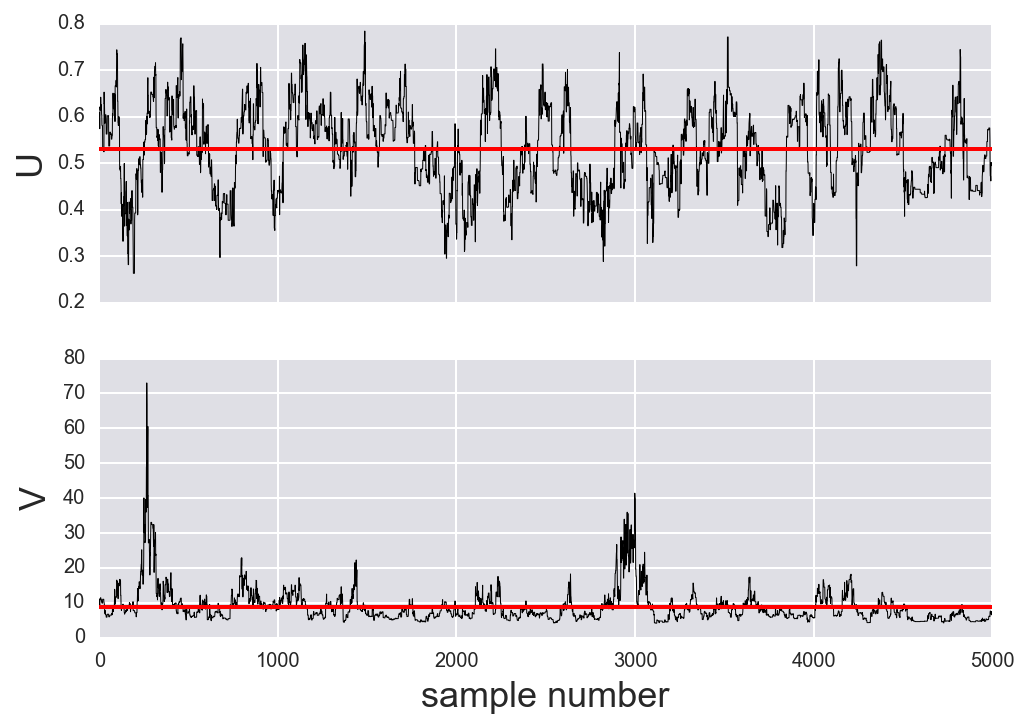

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i+3], 'k-', lw=0.5)
    ax[i].plot([0, 5000-1], 
             [sampler.chain[0,:,i+3].mean(), sampler.chain[0,:,i+3].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('U')
ax[1].set_ylabel('V')

(0, 11)

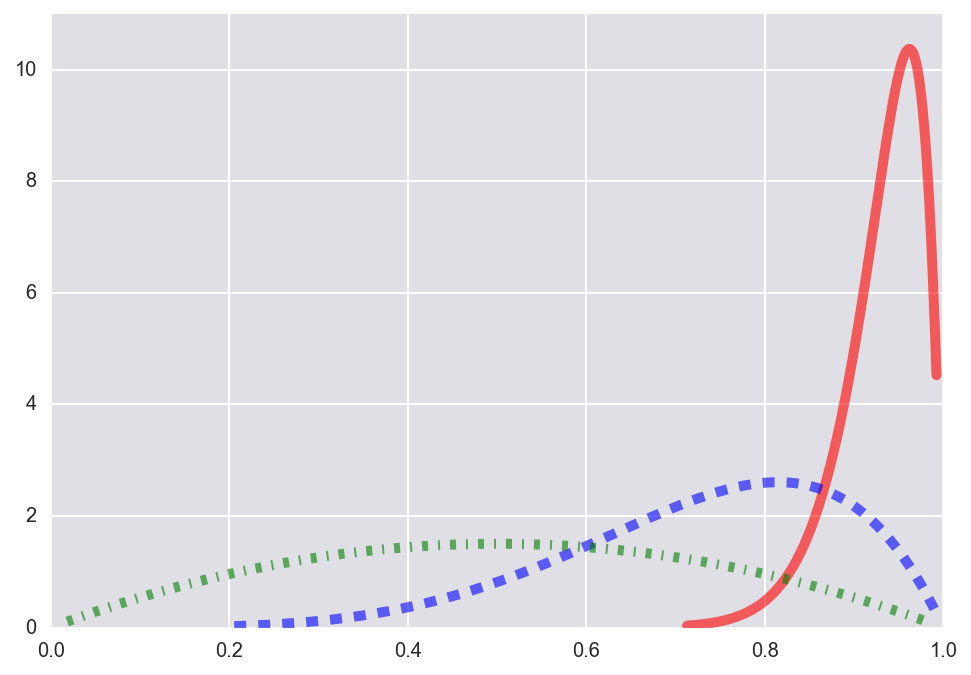

In [38]:
from scipy.stats import beta
u1= .93
v1= 29
a1= u1*v1
b1= (1-u1)*v1

u2= 0.73
v2= 7.44
a2= u2*v2
b2= (1-u2)*v2

u3= 0.5
v3= 4.01
a3= u3*v3
b3= (1-u3)*v3

x1 = np.linspace(beta.ppf(0.001,  a1, b1),
                beta.ppf(0.999,a, b), 200)
x2 = np.linspace(beta.ppf(0.001,  a2, b2),
                beta.ppf(0.999,a2, b2), 200)
x3 = np.linspace(beta.ppf(0.001,  a3, b3),
                beta.ppf(0.999,a3, b3), 200)

plt.plot(x1, beta.pdf(x1, a1, b1),'r-', lw=5, alpha=0.6, label='beta pdf')
plt.plot(x2, beta.pdf(x2, a2, b2),'b--', lw=5, alpha=0.6, label='beta pdf')
plt.plot(x3, beta.pdf(x3, a3, b3),'g-.', lw=5, alpha=0.6, label='beta pdf')
plt.ylim([0, 11])

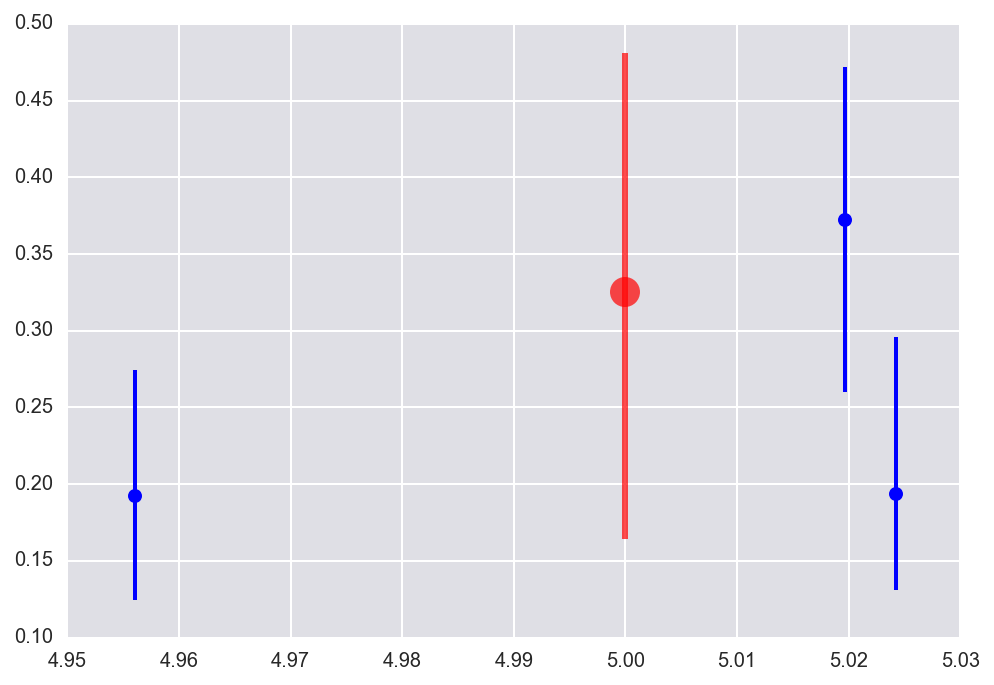

In [29]:
fig, ax= plt.subplots()
plot_with_error_bars(modes_p, mode_u, np.transpose(hpd_p), betaerr, ax= ax, x_mean= i)
plt.show()